In [1]:
# Physics informed neural networks

import numpy as np
import random
import matplotlib.pyplot as plt


# Reaction function
def reaction(u0, rho, dt):
    """ solution of du/dt = rho*u*(1-u) with u0 = u(x,t=0) """
    numerator = u0 * np.exp(rho * dt)
    denominator = u0 * np.exp(rho * dt) + 1 - u0
    u = numerator / denominator
    return u

def reaction_solution(rho, x, tgrid):
    """ discrete solution of du/dt = rho*u*(1-u) with u0 = u(x,t=0) """
    
    # initial value: u0 = u(x,t=0)
    u0 = lambda x: np.exp(-np.power((x - np.pi)/(np.pi/4), 2.)/2.) # + np.random.uniform(-0.05,0.05,256)
    u0 = u0(x).squeeze() # (256,) : u(0),...,u(2pi)
    
    # function
    u = reaction(u0, rho, tgrid) # (100,256)
    u = u.flatten() # (25600,)
    return u



# number of points
nx=256
nt=100

# pde parameters
rho=1

# input parameters
x = np.linspace(0, 2*np.pi, nx, endpoint=False).reshape(-1, 1) # (256,1): [0,...,2pi].T
x_noinit = x[1:]                                               # (255,1): [0.0245,...,2pi].T 
t = np.linspace(0, 1, nt).reshape(-1, 1) # (100,1): [0,...,1].T
t_noinit = t[1:]                         # (99,1):  [0.01,...,1].T


# grid parameters with initial condition
xgrid, tgrid = np.meshgrid(x, t) # xgrid (100,256) = [[0......2pi],
                                 #                    [0......2pi],
                                 #                    [   ...    ]
                                 #                    [0......2pi]], 
                                 #
                                 # tgrid (100,256) = [[0........0],
                                 #                    [0.01..0.01],
                                 #                    [    ...   ]
                                 #                    [1........1]]
X_grid_flatten = np.hstack((xgrid.flatten()[:, None], tgrid.flatten()[:, None])) 
# X_flatten (25600,2) = [[0,     0],
#                        [0.0245,0],
#                        [...,   0],
#                        [2pi,   0],
#                           ....
#                           ....
#                        [0,     1]
#                        [0.0245,1],
#                        [...,   1],
#                        [2pi,   1]]  


# grid parameters without initial conditions
xgrid_noinit, tgrid_noinit = np.meshgrid(x_noinit, t_noinit) 
# xgrid_noinit (99,255) = [[0.0245......2pi],
#                          [0.0245......2pi],
#                          [       ...     ]
#                          [0.0245......2pi]], 
#
# tgrid_noinit (99,255) = [[0.01........0.01],
#                          [0.02........0.02],
#                          [       ...      ]
#                          [1..............1]]

X_grid_flatten_noinit = np.hstack((xgrid_noinit.flatten()[:, None], tgrid_noinit.flatten()[:, None]))
# X_flatten_noinit  (25245,2) = [[0.0245,0.01],
#                                [...,    0.01],
#                                [2pi,    0.01],
#                                     ....
#                                     ....
#                                [0.0245,   1],
#                                [...,      1],
#                                [2pi,      1]]   


#############################################
##########   PDE Exact Solution    ##########
#############################################

u_values = reaction_solution(rho, x, tgrid).reshape(-1, 1) # (25600,1) 
ugrid = u_values.reshape(len(t), len(x))  #  (100,256) : (t,x) grid


#############################################
########## Initial condition (t=0) ##########
#############################################

N0 = x.shape[0] # number of samples

t0 = np.array([t[0]]*N0).reshape(-1, 1)  # (256,1) : [0,...,0].T 
X_0 = np.hstack((x, t0))                 # (256,2) : [[0,...,2pi].T,[0,...,0].T] 
Y_0 = ugrid[0:1,:].T                     # (256,1) : [u(x1,t=0),u(x2,0),.....,u(x256,0)].T


############################################
##########  Boundary conditions  ###########
############################################

Nbc = t.shape[0] # number of samples

xL = np.array([x[0]]*Nbc).reshape(-1, 1) # (100,1) : [0,...,0].T 
X_bc_L = np.hstack((xL, t))              # (100,2) : [[0   0    ],
                                         #            [0   0.01 ],
                                         #               ...
                                         #            [0   1    ]]
                
                
xR = np.array([x[-1]]*Nbc).reshape(-1, 1) # (100,1) : [2pi,...,2pi].T 
X_bc_R = np.hstack((xR, t))               # (100,2) : [[2pi   0    ],
                                          #            [2pi   0.01 ],
                                          #                ...
                                          #            [2pi   1    ]]
                

#############################################
#############   PDE condition    ############
#############################################

Npde = t.shape[0] # number of samples

def set_seed(seed):
    """Set a fixed random configuration"""
    random.seed(seed)
    np.random.seed(seed)
        
def sample_random(X_all, N):
    """Given an array of (x,t) points, sample Npde points from this."""
    set_seed(0)

    idx = np.random.choice(X_all.shape[0], N, replace=False)
    X_sampled = X_all[idx, :]

    return X_sampled

X_pde = sample_random(X_grid_flatten_noinit, Npde) # (100,2): random (x,t) pairs 


############   TRAINING   ############ 

#initial conditions 
train_X0 = X_0.T # (2,256): [[0, .... ,2pi]
                 #           [0,...0,,,,,0]]   
    
train_Y0 = Y_0.T # (1,256)

#boundary conditions
train_Xbc_L = X_bc_L.T # (2,100): [[ 0,0,.......,0]
                       #            [ 0, 0.01,....1 ]] 
    
train_Xbc_R = X_bc_R.T # (2,100):  [[2pi, 2pi, ...., 2pi]
                       #            [0, 0.01, ....., 1  ]] 
    
#pde condition
    
train_Xpde = X_pde.T # [[.....x........]
                    #  [......t...... ]]


############## PREDICTING  ###############

predict_X = X_grid_flatten.T # (2, 25600)
predict_Y = u_values.T # (1, 25600)


In [2]:
###################################################################################################################
########################################   Neural Network Functions   #############################################
###################################################################################################################


##################################################
########       Activation Functions        #######
##################################################

def relu(Z, target):
    """
    RELU activation function

    Arguments:
    Z -- numpy array of any shape
    target -- str: 'forward', 'first_derivative' or 'second_derivative'

    Returns:
    A -- output of relu(z), relu'(z), or relu''(z). Same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    if target == 'forward':
        A = np.maximum(0,Z)
        
    elif target == 'first_derivative':
        A = np.array(Z, copy=True)
        A[Z>0]=1
        A[Z<=0]=0
        
    elif target == 'second_derivative':
        A = Z*0 
        
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def sigmoid(Z, target):
    """
    sigmoid activation function
    
    Arguments:
    Z      -- numpy array of any shape
    target -- str: 'forward', 'first_derivative' or 'second_derivative'
    
    Returns:
    A     -- output of sigmoid(z), sigmoid'(z), or sigmoid''(z). Same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    if target == 'forward':
        A = 1/(1+np.exp(-Z))
    
    elif target == 'first_derivative':
        A = (np.exp(-Z))/(1+np.exp(-Z))**2
    
    elif target == 'second_derivative':
        A = 2 * (np.exp(-2*Z))/(1+np.exp(-Z))**3 - (np.exp(-Z))/(1+np.exp(-Z))**2
        
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache


def tanh(Z, target):
    """
    Tanh activation function

    Arguments:
    Z -- numpy array of any shape
    target -- str: 'forward', 'first_derivative' or 'second_derivative'

    Returns:
    A -- output of tanh(z), tanh'(z), or tanh''(z). Same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """

    if target == 'forward':
        A = (np.exp(Z) - np.exp(-Z))/(np.exp(Z) + np.exp(-Z))
        
    elif target == 'first_derivative':
        A = 4/(np.exp(Z) + np.exp(-Z))**2
        
    elif target == 'second_derivative':
        A = (8 * np.exp(-Z))/(np.exp(Z) + np.exp(-Z))**3 - (8 * np.exp(Z))/(np.exp(Z) + np.exp(-Z))**3
        
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def identity(Z, target):
    """
    Identity activation function

    Arguments:
    Z -- numpy array of any shape
    target -- str: 'forward', 'first_derivative' or 'second_derivative'

    Returns:
    A -- output of identity(z), identity'(z), or identity''(z). Same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """

    if target == 'forward':
        A = Z
        
    elif target == 'first_derivative':
        temp = np.zeros((Z.shape[0],Z.shape[1]))
        temp[:] = 1
        A = temp
        
    elif target == 'second_derivative':
        temp = np.zeros((Z.shape[0],Z.shape[1]))
        A = temp
        
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache, target):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    target -- str: 'forward', 'pde_first_order' or 'pde_second_order'

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    if target == 'backward':
        dZ = np.array(dA, copy=True) # just converting dz to a correct object.
        dZ[Z <= 0] = 0 # --> dA * ds/dZ
        
    elif target == 'pde_first_order':
        dZ = dA * 0 # --> dA * d2s/dZ2
    
    elif target == 'pde_second_order':
        dZ = dA * 0 # --> dA * d3s/dZ3
    
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache, target):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    target -- str: 'forward', 'pde_first_order' or 'pde_second_order'

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache

    if target == 'backward':
        s = 1/(1+np.exp(-Z)) # --> ds/dZ = s*(1-s)
        dZ = dA * s * (1-s)
        
    elif target == 'pde_first_order':
        s = 1/(1+np.exp(-Z)) # --> d2s/dZ2 = (1 - 2*s) * (s-s**2)
        dZ = dA * (1 - 2*s) * (s-s**2)
    
    elif target == 'pde_second_order':
        s = 1/(1+np.exp(-Z)) # --> d3s/dZ3 = (1 - 6*s + 6*s**2) * (s-s**2)
        dZ = dA * (1 - 6*s + 6*s**2) * (s-s**2)
          
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def tanh_backward(dA, cache, target):
    """
    Implement the backward propagation for a single TANH unit.

    Arguments:
    dA -- post-activation gradient of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    target -- str: 'forward', 'pde_first_order' or 'pde_second_order'

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    if target == 'backward':
        s = (np.exp(Z) - np.exp(-Z))/(np.exp(Z) + np.exp(-Z)) # --> ds/dZ = (1 - s**2) 
        dZ = dA * (1 - s**2)
        
    elif target == 'pde_first_order':
        s = (np.exp(Z) - np.exp(-Z))/(np.exp(Z) + np.exp(-Z)) # --> d2s/dZ2 = -2s(1 - s**2) 
        dZ = dA * -2*s*(1 - s**2)
    
    elif target == 'pde_second_order':
        s = (np.exp(Z) - np.exp(-Z))/(np.exp(Z) + np.exp(-Z)) # --> d3s/dZ3 = -2*(1- s**2) + 6*s**2*(1-s**2)
        dZ = dA * (-2 + 6*s**2) * (1-s**2)
        
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def identity_backward(dA, cache, target):
    """
    Implement the backward propagation for a single IDENTITY unit.

    Arguments:
    dA -- post-activation gradient of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    target -- str: 'forward', 'pde_first_order' or 'pde_second_order'

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache

    
    if target == 'backward':
        s = Z # --> ds/dZ = Z/Z
        temp = np.zeros((Z.shape[0],Z.shape[1]))
        temp[:] = 1
        dZ = dA * temp
        
    elif target == 'pde_first_order':
        s = Z # --> d2s/dZ2 = 0
        temp = np.zeros((Z.shape[0],Z.shape[1]))
        dZ = dA * temp
    
    elif target == 'pde_second_order':
        s = Z # --> d3s/dZ3 = 0
        temp = np.zeros((Z.shape[0],Z.shape[1]))
        dZ = dA * temp
    
    assert (dZ.shape == Z.shape)
    
    return dZ

##################################################
########  Initialize Parameters Function   #######
##################################################

def initialize_parameters(layers_dims):
    """
    Arguments:
    layers_dims -- list containing the dimensions of each layer in the network (including the input layer)
    
    Returns:
    parameters --  dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                   Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                   bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(2)
    parameters = {}

    for l in range(1, len(layers_dims)):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) / np.sqrt(layers_dims[l-1]) 
        parameters['b' + str(l)] = np.random.randn(layers_dims[l], 1) * 0.01
        
        assert(parameters['W' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layers_dims[l], 1))

        
    return parameters


##################################################
########   Forward Propagation Functions   #######
##################################################

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid", "relu" or "tanh"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z, "forward")
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z , "forward")
        
    elif activation == "tanh":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z, "forward")
    
    elif activation == "identity":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = identity(Z, "forward")
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters, bulk_activation):
    """
    Implement: 
    forward propagation for the bulk LINEAR->ACTIVATION layers
    
    forward propagation for the last LINEAR->ACTIVATION layer
    *In PINNs the activation function of the last layer is the identity function 
     because the output is a real number
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters()
    bulk_activation -- activation function in the bulk
    
    Returns:
    AL -- Ouput of the neural network. last value of the last LINEAR->ACTIVATION layer
    caches -- list of caches, e.g., caches[0] = (linear_cache, activation cache) = ((A0,W1,b1),Z1)
    """

    caches = []
    A = X
    L = len(parameters) // 2   # number of layers in the neural network (without the input layer)
    
    # Bulk layers
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = bulk_activation)
        caches.append(cache)
    
    # Last layer
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "identity")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

##################################################
#######           Cost Function            #######
##################################################

def compute_cost(AL, Y):
    """
    Implement the cost function.

    Arguments:
    AL -- output of the neural network, shape (1, number of examples)
    Y --  true solution vector, e.g. exact solution of the pde

    Returns:
    cost -- mean squared error or cross-entropy cost
    """
    
    m = AL.shape[1]

    #cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = (1/m)*np.sum((AL - Y) ** 2)
    
    cost = np.squeeze(cost) # To make sure your cost's shape is what we expect (e.g. it turns [[17]] into 17)
    assert(cost.shape == ())
    
    return cost

#################################################
#######   Autograd Propagation Functions ########
#################################################


###### Reverse: last layer to first layer #######
def linear_autogradL(dZ, cache):
    """
    Implement the linear portion of autograd propagation (reverse) for a single layer (layer l)

    Arguments:
    dZ -- Gradient of AL with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of AL with respect to the activation (of the previous layer l-1), same shape as A_prev
    """
    A_prev, W, b = cache
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    
    return dA_prev

def linear_activation_autogradL(dA, cache, activation):
    """
    Implement the autograd propagation (reverse) for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid", "relu", "tanh", ...
    
    Returns:
    dA_prev -- Gradient of AL with respect to the activation (of the previous layer l-1), same shape as A_prev
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache, target="backward")
        dA_prev = linear_autogradL(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache, target="backward")
        dA_prev = linear_autogradL(dZ, linear_cache)
        
    elif activation == "tanh":
        dZ = tanh_backward(dA, activation_cache, target="backward")
        dA_prev = linear_autogradL(dZ, linear_cache)
    
    elif activation == "identity":
        dZ = identity_backward(dA, activation_cache, target="backward")
        dA_prev = linear_autogradL(dZ, linear_cache)
    
    return dA_prev, dZ


###### Forward: first layer to last layer #######
def linear_autogradR(dz, cache):

    A_prev, W, b = cache
    da_prev = np.dot(W,dz)
    
    return da_prev

def linear_activation_autogradR(dz, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        da_prev = linear_autogradR(dz,linear_cache)
        dz = relu_backward(da_prev, activation_cache, target="backward")
        
    elif activation == "sigmoid":
        da_prev = linear_autogradR(dz,linear_cache)
        dz = sigmoid_backward(da_prev, activation_cache, target="backward")
        
    elif activation == "tanh":
        da_prev = linear_autogradR(dz,linear_cache)
        dz = tanh_backward(da_prev, activation_cache, target="backward")
            
    elif activation == "identity":
        da_prev = linear_autogradR(dz,linear_cache)
        dz = identity_backward(da_prev, activation_cache, target="backward")
    
    return da_prev, dz

####### General: calls reverse and forward modes #######
def L_model_autograd(dAL, caches, bulk_activation, mode):

    if mode=="reverse":
        autogradL = {}
        L = len(caches) # the number of layers
    
        # Lth layer 
        # Inputs: "caches", "bulk activation". Outputs: "grads["dAL"]
        autogradL["dA" + str(L)] = dAL
        current_cache = caches[L-1]
        autogradL["dA" + str(L-1)], autogradL["dZ" + str(L)] = linear_activation_autogradL(autogradL["dA" + str(L)], current_cache, activation = "identity")
    
        # Buk layers
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dZ_temp = linear_activation_autogradL(autogradL["dA" + str(l + 1)], current_cache, activation = bulk_activation)
            autogradL["dA" + str(l)] = dA_prev_temp
            autogradL["dZ" + str(l+1)] = dZ_temp

        return autogradL
    
    elif mode=="forward":
        autogradR = {}
        L = len(caches) # the number of layers
        
        linear_cache, activation_cache = caches[0]
        A0, W1, b1 = linear_cache
        temp = np.zeros((A0.shape[0],A0.shape[1]))
        temp[1,:] = 1 
        
        # Bulk
        autogradR["dz" + str(0)] = temp 
        for l in range(L-1):
            current_cache = caches[l]
            autogradR["da" + str(l)], autogradR["dz" + str(l+1)] = linear_activation_autogradR(autogradR["dz" + str(l)], current_cache, activation = bulk_activation)
        
        # Lth layer
        current_cache = caches[L-1]
        autogradR["da" + str(L-1)], autogradR["dz" + str(L)] = linear_activation_autogradR(autogradR["dz" + str(L-1)], current_cache, activation = "identity")

        return autogradR
    
    else:
        quit()


        
##################################################
#######   Backward Propagation Functions   #######
##################################################

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache, "backward")
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache, "backward")
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "tanh":
        dZ = tanh_backward(dA, activation_cache, "backward")
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    elif activation == "identity":
        dZ = identity_backward(dA, activation_cache, "backward")
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches, bulk_activation, loss):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    if loss == "binary":
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) 
    
    elif loss == "mean":
        dAL = 2 * (AL - Y)
        
    else:
        quit()
        
    
    # Lth layer ([ACTIVATION FUNCTION] LAST LAYER -> LINEAR) gradients. 
    # Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, activation = "identity")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for l in reversed(range(L-1)):
        # lth layer: ([ACTIVATION FUNCTION] BULK LAYERS -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = bulk_activation)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


##################################################
###### Backward Propagation Functions PDEs  ######
##################################################
def linear_backward_pde(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward_pde(dA, cache, activation, target):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache, target)
        dA_prev, dW, db = linear_backward_pde(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache, target)
        dA_prev, dW, db = linear_backward_pde(dZ, linear_cache)
        
    elif activation == "tanh":
        dZ = tanh_backward(dA, activation_cache, target)
        dA_prev, dW, db = linear_backward_pde(dZ, linear_cache)
    
    elif activation == "identity":
        dZ = identity_backward(dA, activation_cache, target)
        dA_prev, dW, db = linear_backward_pde(dZ, linear_cache)
    
    return dA_prev, dW, db



def L_model_backward_pde(AL, f, caches, bulk_activation, loss, term, rho):

    gradsPDE = {}

    L = len(caches) # the number of layers
    m = f.shape[1]
    
    # Caculate dAL = dJ/daL
    if loss == "mean":
        
        # PDE1 (first term) : du/dt
        if term == "pde1":
            dAL = 2 * f
            
        # PDE2 (second term): -rho*u
        elif term == "pde2":    
            dAL = -2 * rho * f
            
        # PDE3 (third term) : +rho*u**2    
        elif term == "pde3":
            dAL = 4 * rho * f * AL
        else:
            quit()
            
    else:
        quit()
    
    
    # PDE1 (first term)
    if term == "pde1":
        
        # Compute the autograd (from right to left). Specific to dz/dt
        autogradsR = L_model_autograd(1, caches, bulk_activation, "forward")
        
        # Compute the autograd (from left to right). General solution
        autogradsL = L_model_autograd(dAL, caches, bulk_activation, "reverse")
        
        gradsPDE_w = {}
        gradsPDE_g = {}

        # gradsPDE_w.
        for l in reversed(range(L)):
            assert (autogradsL["dZ"+str(l+1)].shape[1] == autogradsR["dz"+str(l)].shape[1])
            m = autogradsL["dZ"+str(l+1)].shape[1]
            gradsPDE_w["dW" + str(l+1)] = 1./m * np.dot(autogradsL["dZ"+str(l+1)], autogradsR["dz"+str(l)].T)
        
             

        #L=3
        dAL = autogradsL["dA"+str(L-1)] * autogradsR["da"+str(L-2)]
        current_cache = caches[L-2]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward_pde(dAL, current_cache, activation = bulk_activation, target="pde_first_order")
        gradsPDE_g["dA" + str(L-2) + "_g" + str(L-1)] = dA_prev_temp
        gradsPDE_g["dW" + str(L-1) + "_g" + str(L-1)] = dW_temp
        gradsPDE_g["db" + str(L-1) + "_g" + str(L-1)] = db_temp
    
        for l in reversed(range(L-2)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = linear_activation_backward_pde(gradsPDE_g["dA" + str(l + 1) + "_g" + str(L-1)], current_cache, activation = bulk_activation, target="backward")
            gradsPDE_g["dA" + str(l) + "_g" + str(L-1)] = dA_prev_temp
            gradsPDE_g["dW" + str(l + 1) + "_g" + str(L-1)] = dW_temp
            gradsPDE_g["db" + str(l + 1) + "_g" + str(L-1)] = db_temp
        
        #L=2
        dAL = autogradsL["dA"+str(L-2)] * autogradsR["da"+str(L-3)]
        current_cache = caches[L-3]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward_pde(dAL, current_cache, activation = bulk_activation, target="pde_first_order")
        gradsPDE_g["dA" + str(L-3) + "_g" + str(L-2)] = dA_prev_temp
        gradsPDE_g["dW" + str(L-2) + "_g" + str(L-2)] = dW_temp
        gradsPDE_g["db" + str(L-2) + "_g" + str(L-2)] = db_temp
    
        for l in reversed(range(L-3)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = linear_activation_backward_pde(gradsPDE_g["dA" + str(l + 1) + "_g" + str(L-2)], current_cache, activation = bulk_activation, target="backward")
            gradsPDE_g["dA" + str(l) + "_g" + str(L-2)] = dA_prev_temp
            gradsPDE_g["dW" + str(l + 1) + "_g" + str(L-2)] = dW_temp
            gradsPDE_g["db" + str(l + 1) + "_g" + str(L-2)] = db_temp
        
        
        #L=1
        dAL = autogradsL["dA"+str(L-3)] * autogradsR["da"+str(L-4)]
        current_cache = caches[L-4]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward_pde(dAL, current_cache, activation = bulk_activation, target="pde_first_order")
        gradsPDE_g["dA" + str(L-4) + "_g" + str(L-3)] = dA_prev_temp
        gradsPDE_g["dW" + str(L-3) + "_g" + str(L-3)] = dW_temp
        gradsPDE_g["db" + str(L-3) + "_g" + str(L-3)] = db_temp

            

        # TOTAL
        gradsPDE["dW" + str(4)] = gradsPDE_w["dW" + str(4)]
        gradsPDE["dW" + str(3)] = gradsPDE_g["dW" + str(3) + "_g" + str(3)] + gradsPDE_w["dW" + str(3)]
        gradsPDE["dW" + str(2)] = gradsPDE_g["dW" + str(2) + "_g" + str(3)] + gradsPDE_g["dW" + str(2) + "_g" + str(2)] + gradsPDE_w["dW" + str(2)]
        gradsPDE["dW" + str(1)] = gradsPDE_g["dW" + str(1) + "_g" + str(3)] + gradsPDE_g["dW" + str(1) + "_g" + str(2)] + gradsPDE_g["dW" + str(1) + "_g" + str(1)] + gradsPDE_w["dW" + str(1)]
        
        gradsPDE["db" + str(4)] = 0
        gradsPDE["db" + str(3)] = gradsPDE_g["db" + str(3) + "_g" + str(3)] 
        gradsPDE["db" + str(2)] = gradsPDE_g["db" + str(2) + "_g" + str(3)] + gradsPDE_g["db" + str(2) + "_g" + str(2)] 
        gradsPDE["db" + str(1)] = gradsPDE_g["db" + str(1) + "_g" + str(3)] + gradsPDE_g["db" + str(1) + "_g" + str(2)] + gradsPDE_g["db" + str(1) + "_g" + str(1)]        
        
        
    
    
    # PDE2 (second term)
    elif term == "pde2": 
        
        # Lth layer ([ACTIVATION FUNCTION] LAST LAYER -> LINEAR) gradients. 
        # Inputs: "AL, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
        current_cache = caches[L-1]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, activation = "identity") # correct: no need of linear_activation_backward_pde
        gradsPDE["dA" + str(L-1)] = dA_prev_temp
        gradsPDE["dW" + str(L)] = dW_temp
        gradsPDE["db" + str(L)] = db_temp

        for l in reversed(range(L-1)):
            # lth layer: ([ACTIVATION FUNCTION] BULK LAYERS -> LINEAR) gradients.
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = linear_activation_backward(gradsPDE["dA" + str(l + 1)], current_cache, activation = bulk_activation) # correct: no need of linear_activation_backward_pde 
            gradsPDE["dA" + str(l)] = dA_prev_temp
            gradsPDE["dW" + str(l + 1)] = dW_temp
            gradsPDE["db" + str(l + 1)] = db_temp
    
    
    # PDE3 (third term)
    elif term == "pde3": 
        
        # Lth layer ([ACTIVATION FUNCTION] LAST LAYER -> LINEAR) gradients. 
        # Inputs: "AL, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
        current_cache = caches[L-1]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, activation = "identity") # correct: no need of linear_activation_backward_pde
        gradsPDE["dA" + str(L-1)] = dA_prev_temp
        gradsPDE["dW" + str(L)] = dW_temp
        gradsPDE["db" + str(L)] = db_temp

        for l in reversed(range(L-1)):
            # lth layer: ([ACTIVATION FUNCTION] BULK LAYERS -> LINEAR) gradients.
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = linear_activation_backward(gradsPDE["dA" + str(l + 1)], current_cache, activation = bulk_activation) # correct: no need of linear_activation_backward_pde 
            gradsPDE["dA" + str(l)] = dA_prev_temp
            gradsPDE["dW" + str(l + 1)] = dW_temp
            gradsPDE["db" + str(l + 1)] = db_temp
    
    else:
        quit()

    return gradsPDE



##################################################
#######  Gradient Descent Update Function  #######
##################################################

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

##################################################
#######                PDE                 #######
##################################################

def L_model_pde(AL,caches,bulk_activation):
    """
    This function sets the pde 
    
    Arguments:
    AL --  output data of the neural network 
    caches -- list of the neural network variables, e.g., caches[0] = [[A0,W1,b1],Z1] 
    
    Returns:
    f -- pde expression considering the neural network output
    """    

    ##### pde definition #####
       
    # du/dt - rho*u + rho*u**2 = 0
    
    # first-term
    grads = L_model_autograd(1, caches, bulk_activation, "reverse")
    grad_u = grads["dA" + str(0)]
    u_t = grad_u[1,:]
    
    ##### pde resolution #####
    rho = 1
    f = u_t - rho*AL + rho*AL**2
    
    return f, rho
    
    

In [3]:
#############################################
#######  Physics Informed Neural N.  ########
#############################################


def L_layer_model(X0, Y0, XbcL, XbcR, Xpde, 
                  layers_dims, learning_rate, num_iterations, bulk_activation):
    """
    This function solves the physics informed neural network
    
    Arguments:
    Y0 --   exact solution for the initial condition 
    X0 --   input data for the initial condition
    XbcL -- input data for the left boundary condition 
    XbcR -- input data for the right boundary condition
    Xpde -- input data for the pde condition
    
    Returns:
    parameters -- updated weights and biases
    """

    np.random.seed(1)
                           
    # initialization of weights and biases
    parameters = initialize_parameters(layers_dims)
    
    costs = [] 

    
    for i in range(0, num_iterations):

        ##### forward propagation #####
        
        # initial condition
        AL, caches = L_model_forward(X0, parameters, bulk_activation)
        
        # boundary condition
        ALL, cachesL = L_model_forward(XbcL, parameters, bulk_activation)
        ALR, cachesR = L_model_forward(XbcR, parameters, bulk_activation)
        
        # pde condition
        ALPDE, cachesPDE = L_model_forward(Xpde, parameters, bulk_activation)
        
        
        ##### pde resolution #####
        
        f, rho = L_model_pde(ALPDE, cachesPDE, bulk_activation)
     
        
        ##### cost function #####
        
        
        
        # cost: initial condition
        cost0 = compute_cost(AL, Y0)
        
        # cost: boundary condition
        costBC = compute_cost(ALL, ALR)
        
        # cost: pde
        costPDE = compute_cost(f, 0)
        
        # cost: all
        costALL = cost0 + costBC + costPDE
        
        # print the cost every 100 training example
        if i % 100 == 0:
            print ("cost0, costBC, costPDE, and costALL after iteration %i: %f %f %f %f" %(i, cost0, costBC, costPDE, costALL))
        if i % 100 == 0:
            costs.append(costALL)
        
        
        ##### back propagation #####
        
        # grads: initial condition
        grads0 = L_model_backward(AL, Y0, caches, bulk_activation, 'mean')
        
        # grads: boundary condition -> gradsBC = gradsL + gradsR
        gradsL = L_model_backward(ALL, ALR, cachesL, bulk_activation, 'mean')
        gradsR = L_model_backward(ALR, ALL, cachesR, bulk_activation, 'mean')
        
        gradsBC = {}
        
        for l in range(1, len(layers_dims)):
            gradsBC['dW' + str(l)] = gradsL['dW' + str(l)] + gradsR['dW' + str(l)]
            gradsBC['db' + str(l)] = gradsL['db' + str(l)] + gradsR['db' + str(l)]
        
            assert(gradsBC['dW' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
            assert(gradsBC['db' + str(l)].shape == (layers_dims[l], 1))
            
        
        # grads: pde -> grads(du/dt) - rho*grads(u) + rho*grads(u**2) = gradsPDE1 + gradsPDE2 + gradsPDE3
        gradsPDE1 = L_model_backward_pde(ALPDE, f, cachesPDE, bulk_activation, 'mean', 'pde1', rho)
        gradsPDE2 = L_model_backward_pde(ALPDE, f, cachesPDE, bulk_activation, 'mean', 'pde2', rho)
        gradsPDE3 = L_model_backward_pde(ALPDE, f, cachesPDE, bulk_activation, 'mean', 'pde3', rho) 

        gradsPDE = {}
        for l in range(1, len(layers_dims)):
            gradsPDE['dW' + str(l)] = gradsPDE1['dW' + str(l)] + gradsPDE2['dW' + str(l)] + gradsPDE3['dW' + str(l)]
            gradsPDE['db' + str(l)] = gradsPDE1['db' + str(l)] + gradsPDE2['db' + str(l)] + gradsPDE3['db' + str(l)]
        
            assert(gradsPDE['dW' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
            assert(gradsPDE['db' + str(l)].shape == (layers_dims[l], 1))
        
        
        # grads: all
        grads = {}
        for l in range(1, len(layers_dims)):
            grads['dW' + str(l)] = grads0['dW' + str(l)] + gradsBC['dW' + str(l)] + gradsPDE['dW' + str(l)]
            grads['db' + str(l)] = grads0['db' + str(l)] + gradsBC['db' + str(l)] + gradsPDE['db' + str(l)]
        
            assert(grads['dW' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
            assert(grads['db' + str(l)].shape == (layers_dims[l], 1))
        
        
        ##### gradient descent #####
        
        parameters = update_parameters(parameters, grads, learning_rate)
      
                     
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost_all')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

cost0, costBC, costPDE, and costALL after iteration 0: 0.201095 0.002370 0.008990 0.212454
cost0, costBC, costPDE, and costALL after iteration 100: 0.105549 0.001785 0.006862 0.114196
cost0, costBC, costPDE, and costALL after iteration 200: 0.099334 0.001053 0.005647 0.106034
cost0, costBC, costPDE, and costALL after iteration 300: 0.093044 0.000794 0.005089 0.098927
cost0, costBC, costPDE, and costALL after iteration 400: 0.087049 0.000603 0.004736 0.092387
cost0, costBC, costPDE, and costALL after iteration 500: 0.081329 0.000441 0.004505 0.086275
cost0, costBC, costPDE, and costALL after iteration 600: 0.075862 0.000308 0.004365 0.080535
cost0, costBC, costPDE, and costALL after iteration 700: 0.070663 0.000204 0.004298 0.075165
cost0, costBC, costPDE, and costALL after iteration 800: 0.065783 0.000129 0.004291 0.070203
cost0, costBC, costPDE, and costALL after iteration 900: 0.061294 0.000081 0.004335 0.065710
cost0, costBC, costPDE, and costALL after iteration 1000: 0.057265 0.000

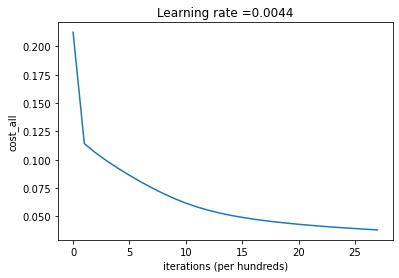

In [4]:
# 4-layer model with 2 input parameters
layers_dims = [2, 50, 50, 50, 1] 

# Training model
parameters = L_layer_model(train_X0, train_Y0, train_Xbc_L, train_Xbc_R, train_Xpde, 
                           layers_dims, learning_rate = 0.0044, num_iterations = 2800, bulk_activation='tanh')

In [5]:
parameters

{'W1': array([[-0.39974627, -0.03571868],
        [-1.51434805,  1.15950721],
        [-1.26840384, -0.59483974],
        [ 0.42577419, -0.85959776],
        [-0.7259933 , -0.6346835 ],
        [ 0.3658912 ,  1.62579371],
        [-0.0801714 , -0.78052405],
        [ 0.34989089, -0.42987987],
        [-0.03346482,  0.83280223],
        [-0.50554026,  0.01483126],
        [-0.58276288, -0.10042527],
        [ 0.21729977, -0.66586169],
        [-0.13339415, -0.15898113],
        [-0.4482073 , -0.81746711],
        [-1.02825312, -0.11383897],
        [-0.11901496,  1.56976646],
        [-1.71812246,  0.07657057],
        [ 0.21439563,  0.96736204],
        [ 0.25735692, -0.58392082],
        [-0.14258987,  0.35800771],
        [-0.18588913,  0.49759721],
        [-1.3227    ,  1.23131605],
        [ 1.03000789, -0.2393958 ],
        [ 0.41745038,  0.02734009],
        [-0.57154583,  0.06240265],
        [ 0.68658126, -0.27590153],
        [-0.25154105, -0.05298003],
        [ 0.24872206, 

In [6]:
AL, caches = L_model_forward(predict_X, parameters, bulk_activation='tanh')

In [7]:
error_abs = np.mean(np.abs(predict_Y - AL))

In [8]:
error_abs

0.15960743117699303

No handles with labels found to put in legend.


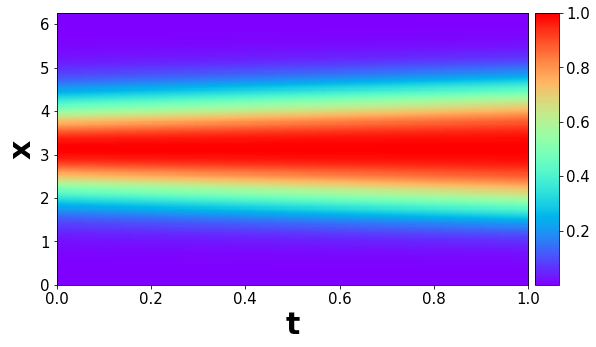

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

"""Visualize exact solution."""
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(ugrid.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

line = np.linspace(x.min(), x.max(), 2)[:,None]

ax.set_xlabel('t', fontweight='bold', size=30)
ax.set_ylabel('x', fontweight='bold', size=30)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={'size': 15}
)

ax.tick_params(labelsize=15)
#def exact_u(ugrid, x, t):
    

    #plt.savefig(f"{path}/exactu_{system}_nu{nu}_beta{beta}_rho{rho}_Nf{N_f}_{layers}_L{L}_source{source}_{u0_str}.pdf")
    #plt.close()

#    return None

No handles with labels found to put in legend.


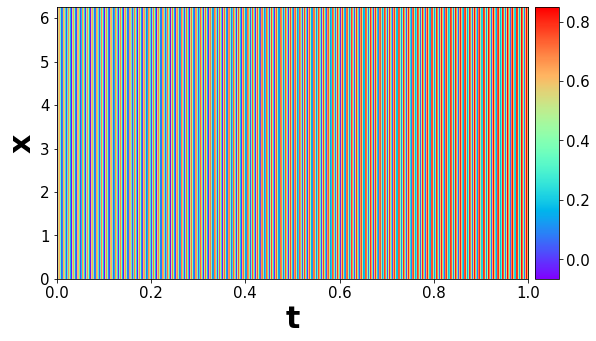

In [10]:
upredict = AL.T
"""Visualize exact solution."""
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(upredict.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

line = np.linspace(x.min(), x.max(), 2)[:,None]

ax.set_xlabel('t', fontweight='bold', size=30)
ax.set_ylabel('x', fontweight='bold', size=30)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={'size': 15}
)

ax.tick_params(labelsize=15)